In [1]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [4]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [5]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [6]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [7]:
train_dir = './train2017/'

image_names = os.listdir(train_dir)
print(len(image_names))

%matplotlib inline

117285


In [8]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

class Dataset:
    
    def __init__(self, folder):
        self.folder = folder
        self.set_to_use = 0
        
    def get_random_example(self):
        subfolder_name = random.choice(os.listdir(self.folder))
        fname = random.choice(os.listdir(os.path.join(self.folder, subfolder_name)))
        return np.array(Image.open(os.path.join(self.folder, subfolder_name, fname)))
    
    def get_batch(self, use_specific=None):
        to_use = self.set_to_use
        if use_specific is not None:
            to_use = use_specific
            
        subfolder_name = "set_" + str(to_use)
        subfolder_path = os.path.join(self.folder, subfolder_name)
        filenames = os.listdir(subfolder_path)
        
        data = np.empty((len(filenames), H, W, C))
        Xs = np.empty((len(filenames), H, W, C))
        Ys = np.empty((len(filenames), H, W, C-1))
        
        for counter, fname in enumerate(filenames):
            x = np.array(Image.open(os.path.join(subfolder_path, fname)))
            if len(x.shape) == 3:
                cropped = crop_center(x, H, W)
                if cropped is not None:
                    data[counter, :, :, :] = RGBtoYCC(cropped)

        data /= 255
        for counter, x in enumerate(data):
            gray = YCCtoGray(x)
            Xs[counter, :, :, :] = gray
            Ys[counter, :, :, :] = x[:, :, 1:]

        data = None
        if use_specific is None:
            self.set_to_use += 1
        return Xs, Ys

In [9]:
def process_image(arr, H, W):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            arr = np.divide(arr, 255)
            gray = YCCtoGray(arr)
            return gray, arr[:, :, 1:]
        return None, None
    return None, None

In [10]:
def generator(image_folder, batch_size):
    batch_features = np.zeros((batch_size, H, W, C))
    batch_labels = np.zeros((batch_size, H, W, C - 1))
    
    filenames = os.listdir(image_folder)
    
    while True:
        count = 0
        while count < batch_size:
            filename = random.choice(filenames)
            arr = np.load(os.path.join(image_folder, filename))
            x, y = process_image(arr, H, W)
            if x is not None:
                batch_features[count, :, :, :] = x
                batch_labels[count, :, :, :] = y
                count += 1
        yield batch_features, batch_labels

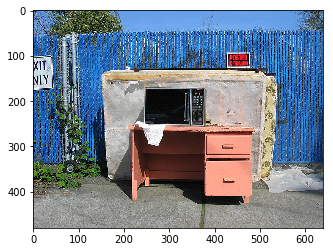

In [11]:
random_example = np.load("./train2017/000000436023.npy")
imshow(random_example)

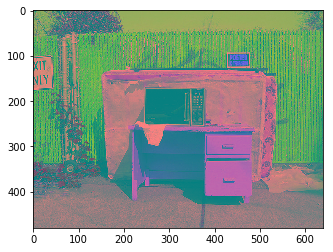

In [12]:
imshow(RGBtoYCC(random_example))

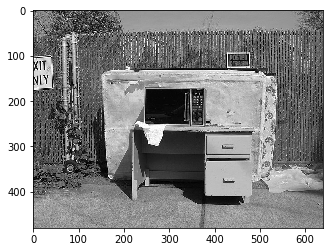

In [13]:
imshow(RGBtoGray(random_example))

In [14]:
x, y = process_image(random_example, H, W)

(256, 256, 3)


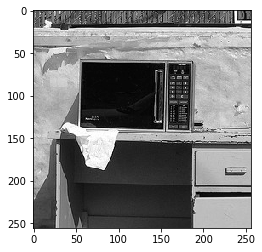

In [15]:
# the x
print(x.shape)
imshow(x)

(256, 256, 2)


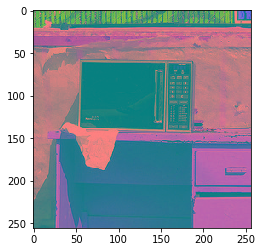

In [16]:
# the y
showing = np.zeros((y.shape[0], y.shape[1], y.shape[2] + 1))
print(y.shape)
showing[:, :, 0] = x[:, :, 0]
showing[:, :, 1:] = y
imshow(showing)

In [17]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [18]:
model_file = 'model.json'
weights_file = 'weights.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = True
save = False
train = False

In [19]:
input_shape = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = H // inter1.output_shape[1]
inter2_scale = H // inter2.output_shape[1]
inter3_scale = H // inter3.output_shape[1]
inter4_scale = H // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
print(hyper)

hyper = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
out = tf.keras.layers.Conv2D(2, (3, 3), padding="same")(hyper)

my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
    print("loaded from save")
else:
    my_model = tf.keras.models.Model(inputs=model.input, outputs=out)

my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')

if train:
    history = my_model.fit_generator(generator(train_dir, 4), steps_per_epoch=25000, epochs=2)

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)
    print("saved weights and model")




Tensor("up_sampling2d/ResizeNearestNeighbor:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("up_sampling2d_1/ResizeNearestNeighbor:0", shape=(?, 256, 256, 128), dtype=float32) Tensor("up_sampling2d_2/ResizeNearestNeighbor:0", shape=(?, 256, 256, 256), dtype=float32) Tensor("up_sampling2d_3/ResizeNearestNeighbor:0", shape=(?, 256, 256, 512), dtype=float32)
Tensor("concatenate/concat:0", shape=(?, 256, 256, 960), dtype=float32)
loaded from save
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
_______________________________________________________

337.2662598076911


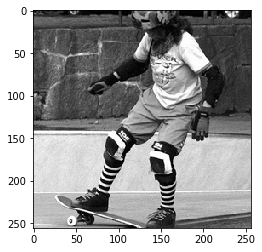

In [64]:
image_name = random.choice(image_names)
showoff = np.load(os.path.join("./train2017/", image_name))
showoff_x, showoff_y = process_image(showoff, H, W)
prediction = my_model.predict(showoff_x[np.newaxis, :, :, :])
prediction = np.reshape(prediction, (H, W, 2))
print(np.sum((showoff_y - prediction)**2))
imshow(showoff_x)
# note that predict and Y_train are both (64, 64, 2) since
# we are only predicting the Cr and Cb components
# to visualize our prediction, have to append in front
# of them the Y channel, X_train[example_index][:, :, 0]

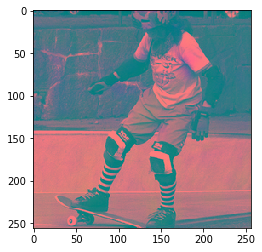

In [65]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
im = np.zeros_like(showoff_x)
im[:, :, 0] = showoff_x[:, :, 0]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
im[im < 0] = 0
imshow(im)

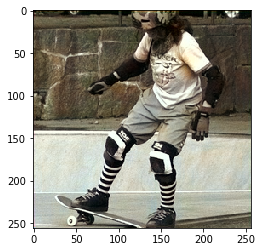

In [66]:
# converting into RGB gives us
im *= 255
imshow(YCCtoRGB(im))

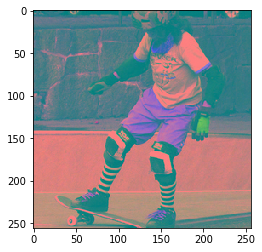

In [67]:
should_be = np.zeros_like(showoff_x)
should_be[:, :, 0] = showoff_x[:, :, 0]
should_be[:, :, 1] = showoff_y[:, :, 0]
should_be[:, :, 2] = showoff_y[:, :, 1]
imshow(should_be)

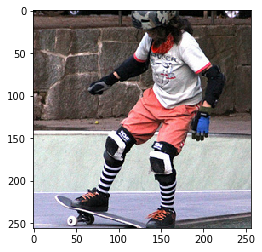

In [68]:
# real image
should_be *= 255
imshow(YCCtoRGB(should_be))